In [1]:
wd <- dirname(dirname(getwd()))
source(paste0(wd,"/mission_control/treasure_map.R"))
source(paste0(wd,"/mission_control/helpers/figures/figure5_themes.R"))

library(tidyverse)
library(RColorBrewer)
library(gridExtra)
library(ggpubr)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ dplyr   1.0.6
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  3.1.2     ✔ forcats 0.5.1
Warning message:
“package ‘tibble’ was built under R version 3.6.3”Warning message:
“package ‘tidyr’ was built under R version 3.6.3”Warning message:
“package ‘purrr’ was built under R version 3.6.3”Warning message:
“package ‘dplyr’ was built under R version 3.6.3”Warning message:
“package ‘forcats’ was built under R version 3.6.3”── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

### Read in prepared validation data

In [2]:
validation_ready <- readRDS(paste0(TMP_DIR,"validation-measure.Rds")) %>% filter(model == "five_latent_purity", complete_rna) %>% unique()
hmf_loo <- readRDS(paste0(TMP_DIR, "validation-loo-cv.Rds"))
cpi_go <- readRDS(paste0(I_DIR, "cpi_go.Rds")) %>% transmute(patient_id = substr(sampleId,0,12), tmb_high = (exp(tmb) > 9))

In [3]:
dd <- (
    validation_ready
        %>% left_join(cpi_go, by = "patient_id")
        %>% select( patient_id, Study, tissue, tmb, tcell, bor, os_days, os_event, os, tmb_high)
        %>% left_join(hmf_loo, by = "patient_id")
        %>% mutate( tissue = str_to_title(tissue))
        %>% drop_na(bor)
        %>% drop_na(tcell)
)

In [4]:
dfs <- list(
    "HMF-CPCT" = dd %>% filter(Study == "HMF-CPCT") %>% unique() %>% mutate(tissue = "Pan-Cancer"),
    "Melanoma" = dd %>% filter(Study == "HMF-CPCT", tissue == "Skin") %>% unique(),
    "Lung" = dd %>% filter(Study == "HMF-CPCT", tissue == "Lung") %>% unique(),
    "Bladder" = dd %>% filter(Study == "HMF-CPCT", tissue == "Bladder") %>% unique(), 
    "Other" = dd %>% filter(Study == "HMF-CPCT", tissue == "Other") %>% unique()
)

In [5]:
saveRDS(dfs, file = paste0(TMP_DIR, "figure5_data.Rds"))

### 0 - Main Distribution Plots
- Main

In [6]:
bar_plot <- function(df, title = "HMF-CPCT", theme, feature1 = "pred_lr", feature2 = "lr_gp") {
    if(title == "HMF-CPCT") { title <- "Pan-Cancer" }
    (
    ggplot( df, aes_string(feature1, fill = feature2)) 
        + geom_histogram(binwidth=.05, color='black', boundary = 0) 
        + labs( x = "Probability of Response", y = "Number of Patients", title = title)
        + scale_x_continuous(breaks=c(.1,.5), labels = scales::percent_format(scale = 100), limits = c(0,1))
        + scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))
        + theme
    )
}

In [7]:
marg <- theme(plot.margin = unit(c(.2,.2,.2,.2), "cm"))

In [8]:
dist_plts1 <- list()
for(i in names(dfs)) {
    if (i %in% c("HMF-CPCT")){ #, "INSPIRE", "VHIO")){ ### Add DRUP here
        dist_plts1[[i]] <- bar_plot( dfs[[i]], i, theme = theme_bar_main) + marg
    } else {
        dist_plts1[[i]] <- bar_plot( dfs[[i]], i, theme = theme_bar_tissue) + marg
    }
}

### 1 - Distibution plots slim

In [9]:
dist_plotter <- function(df, theme) {
    (
    ggplot(data = df, aes(y=Study, x=ct, fill = lr_gp, label = ct)) 
    + geom_bar(stat="identity", width=.8, position = 'stack', color = "black") 
    + scale_fill_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))    
    + geom_text(size = 9, position = position_stack(vjust = .5))
    + labs( x = "HMF CPI samples with complete data")
    + theme + theme(axis.title.x = element_text())
    )
}

In [10]:
eva <- list()
for(i in names(dfs)){
    eva[[i]] <- (
        dfs[[i]]
          %>% unique() 
          %>% group_by(Study, lr_gp) 
          %>% summarise( ct = n())
          %>% mutate(lr_gp = factor(lr_gp, levels = c("High", "Medium", "Low")))
    )
}

dist_plts2 <- list()
for (i in names(dfs)) { 
    dist_plts2[[i]] <- dist_plotter(eva[[i]], theme = theme_dist)
    if( i == "HMF-CPCT"){
        dist_plts2[[i]] <- dist_plts2[[i]] + labs( x = "HMF CPI samples with complete data") + ggtitle("Pan-Cancer") + theme(plot.title = element_blank()) + marg 
    } else {
        dist_plts2[[i]] <- dist_plts2[[i]] + theme(axis.title.x = element_blank()) + ggtitle(i) + theme(plot.title = element_blank()) + marg
    }
}

`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'Study'. You can override using the `.groups` argument.


### 2 - Percent Responders within Groups

In [11]:
computer <- function(df) {
    a <- (df
       %>% group_by(lr_gp)
       %>% summarise(bor = mean(bor), non_bor = 1-mean(bor), ct = n())
       %>% gather("gp", "bor", -ct, -lr_gp)
       %>% mutate(bor2 = paste0(round(bor,2)*100, "%"))
       %>% filter(gp == "bor")
    )
    a
}
plotter <- function(df, theme){
    (
    ggplot(data = df, aes(x=lr_gp, y=bor, fill = gp, label = bor2, color = lr_gp)) 
    + geom_bar(stat="identity", width=.8, position = 'stack', size = 2)     
    + scale_fill_manual(values = c("dark grey", "dark grey"))
    + labs( x = "Responders" )
    + scale_color_manual(values = c('Low' = my_palette[1],'Medium' = my_palette[2],'High' = my_palette[3]))    
    + scale_y_continuous(breaks=c(0,1), labels = scales::percent_format(scale = 100), limits = c(0,1.24))    
    + theme 
    )
}

#### Compute responders

In [12]:
responders <- list()
for(i in names(dfs)) {
    responders[[i]] = computer(dfs[[i]])
}

#### Store responder plots

In [13]:
responder_plts <- list()
for(i in names(responders)) {
    if( i %in% c("HMF-CPCT")) {
        responder_plts[[i]] <- plotter( responders[[i]], theme = theme_compute_main + theme(axis.title.x = element_text())) + geom_text(size = 8.5, vjust = -.2, color = "black") + marg
    } else {
        responder_plts[[i]] <- plotter( responders[[i]], theme = theme_compute_tissue + theme(axis.title.x = element_text())) + geom_text(size = 7, vjust = -.2, color = "black") + marg
    }
}

### 3 - Combining Plots

#### Overall study plots

In [14]:
hmf_main <- arrangeGrob( dist_plts1$`HMF` + theme(legend.position = c(0.75, .75), legend.title=element_blank(), legend.text = element_text(size=18), legend.key.size = unit(1, 'cm')), dist_plts2$`HMF`, responder_plts$`HMF`, layout_matrix = layout2)

#### Tissue plots

In [15]:
layout <- cbind(c(rep(1,3), rep(2,1), rep(3,3)))

In [16]:
mel <- arrangeGrob(dist_plts1[['Melanoma']],dist_plts2[['Melanoma']],responder_plts[['Melanoma']], layout_matrix = layout)
lun <- arrangeGrob(dist_plts1[['Lung']],dist_plts2[['Lung']], responder_plts[['Lung']], layout_matrix = layout)
bla <- arrangeGrob(dist_plts1[['Bladder']],dist_plts2[['Bladder']], responder_plts[['Bladder']], layout_matrix = layout)
oth <- arrangeGrob(dist_plts1[['Other']],dist_plts2[['Other']], responder_plts[['Other']], layout_matrix = layout)
hmf_tissue <- arrangeGrob(mel,lun,bla,oth, ncol = 2)

#### All together

In [17]:
together <- arrangeGrob(hmf_main, hmf_tissue, layout_matrix = rbind(c(1,1,2,2,2),c(1,1,2,2,2)))

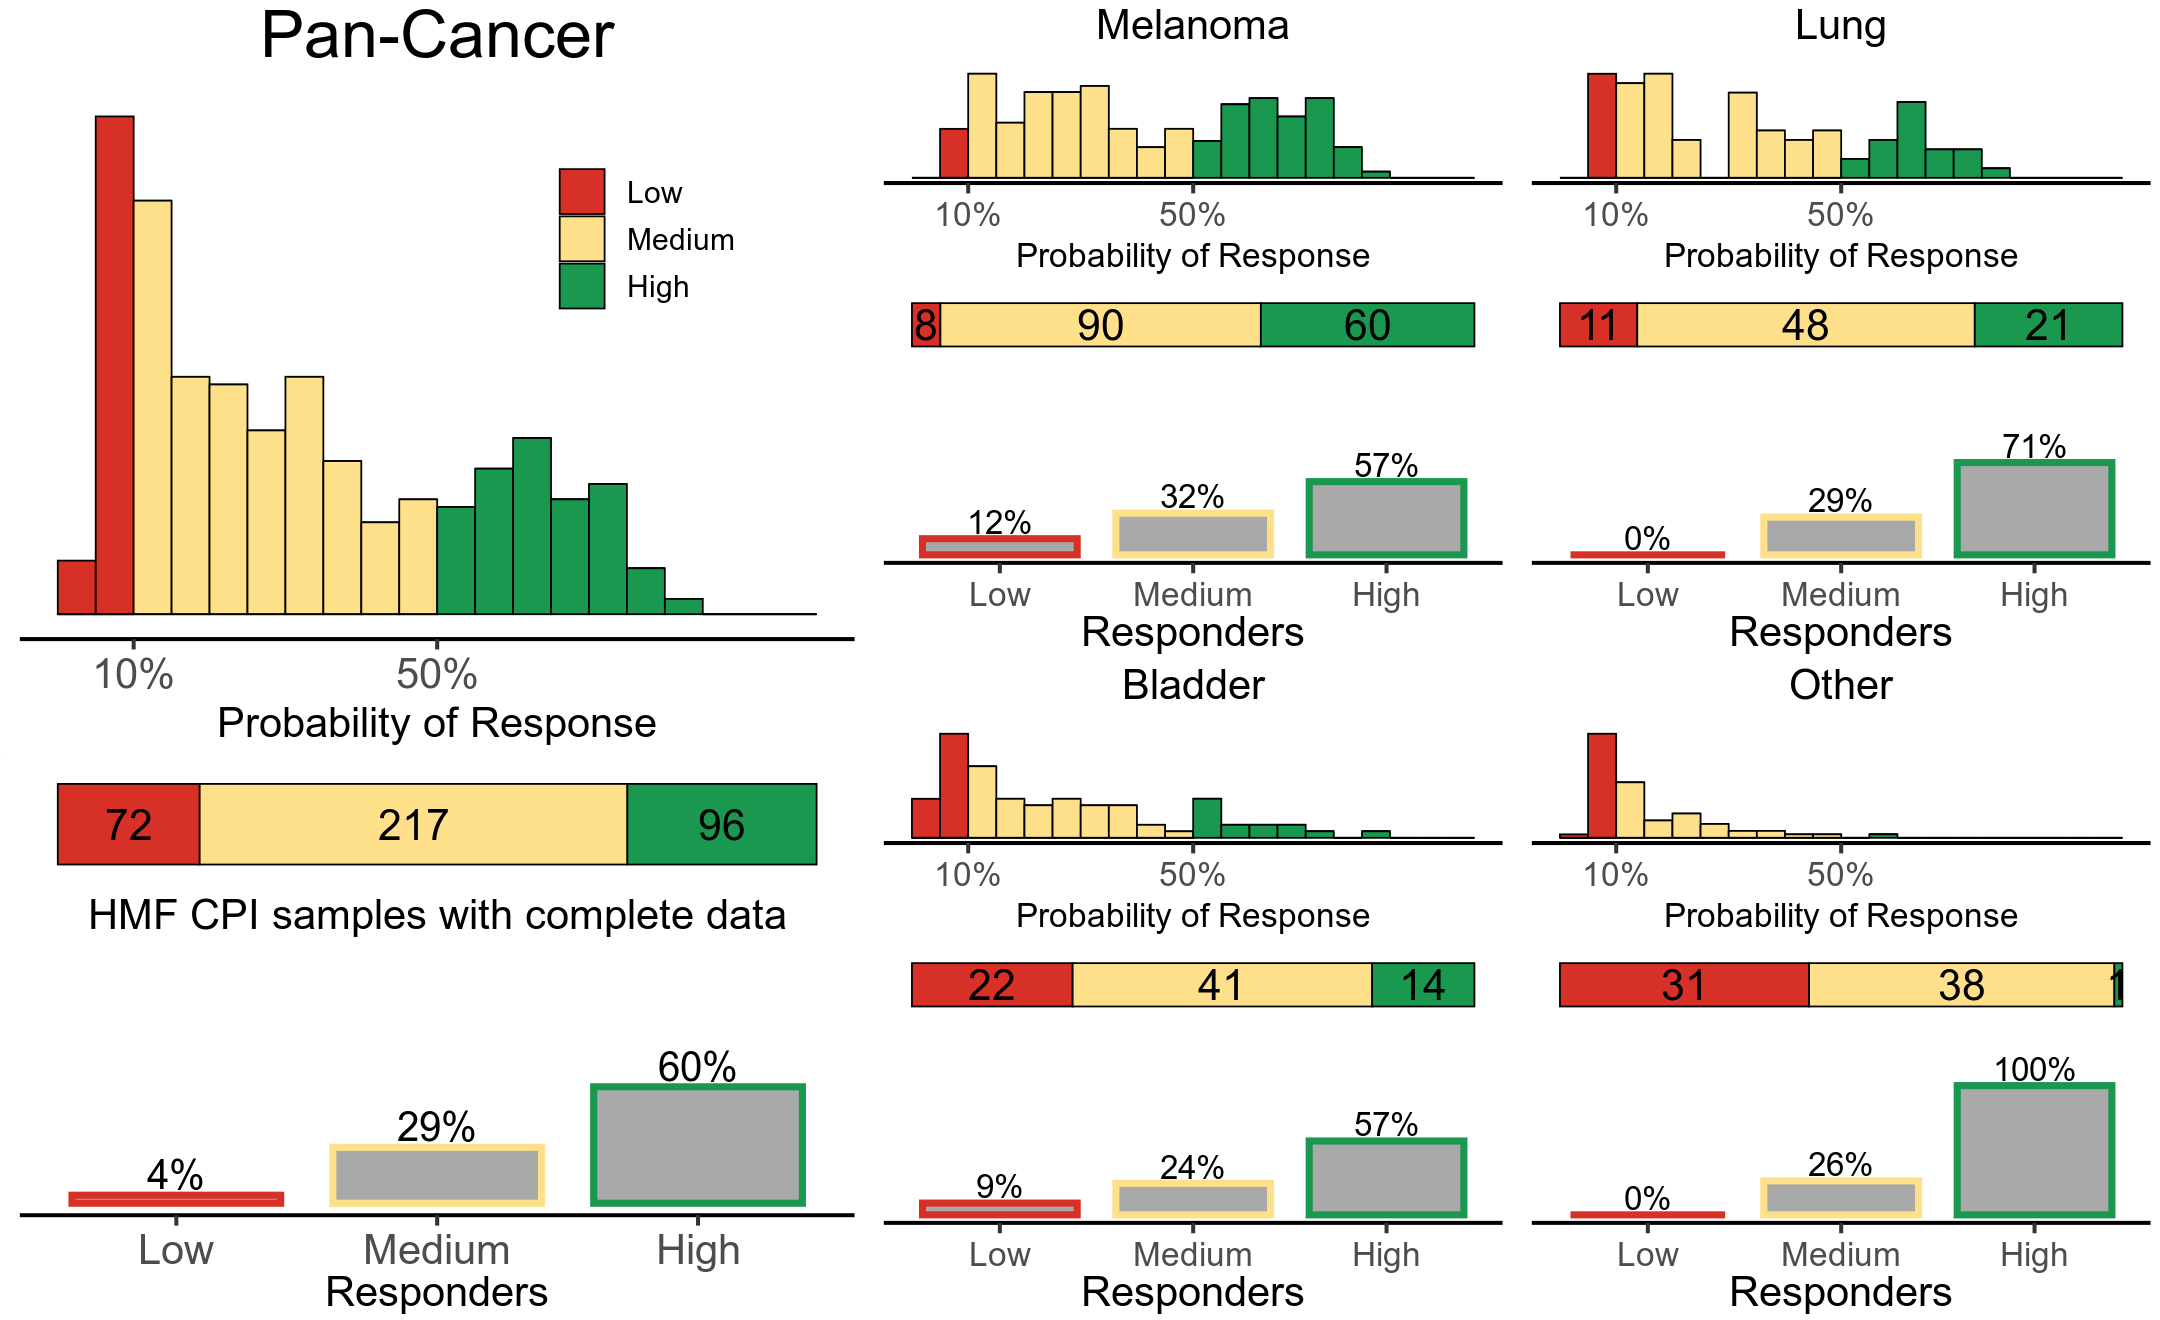

In [18]:
options(repr.plot.width=18, repr.plot.height=11, resolution = 500)
plot(together)

In [19]:
saveRDS( list("abc" = together, "hmf_main" = hmf_main, "hmf_tissue" = hmf_tissue), 
              file = paste0(FIG_DIR, "figure5_b.Rds"))